# Import 

In [103]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anuj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import pandas as pd
import numpy as np
import glob
from collections import defaultdict
from pathlib import Path
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import shuffle


In [2]:
tf.__version__

'2.2.0'

# Data 

## Extraction 

In [3]:
train_list = glob.glob("./stack_overflow_16k/train/*")
test_list = glob.glob("./stack_overflow_16k/test/*")

In [4]:
train = pd.DataFrame(columns = ['label', 'text'])
for dirs in train_list:    
    for file in Path(dirs).iterdir():
        l1=list()
        with open(file, "r", encoding='utf-8') as file_open:
            l = [dirs, file_open.read()]
            l1.append(l)
        l1 = np.vstack(l1)
        train = pd.concat([train, pd.DataFrame(l1, columns=train.columns)], axis=0)
train

,label,text
0,./stack_overflow_16k/train\csharp,"""how to pause loop while time is ticking i hav..."
0,./stack_overflow_16k/train\csharp,"""get the y axis height of webbrowser control d..."
0,./stack_overflow_16k/train\csharp,"""how to skip day when there is no store openin..."
0,./stack_overflow_16k/train\csharp,"""how to add items to a property of type list w..."
0,./stack_overflow_16k/train\csharp,"""what is the default value when create multi d..."
...,...,...
0,./stack_overflow_16k/train\python,"""finding which values are causing runtimewarni..."
0,./stack_overflow_16k/train\python,"""combine lines (deleting line numbers) to make..."
0,./stack_overflow_16k/train\python,"""blank reduce issue object has no attribute sn..."
0,./stack_overflow_16k/train\python,pandas: how to merge columns containing the sa...


In [5]:
train.label.value_counts()

./stack_overflow_16k/train\csharp        2000
./stack_overflow_16k/train\python        2000
./stack_overflow_16k/train\java          2000
./stack_overflow_16k/train\javascript    2000
Name: label, dtype: int64

In [6]:
train.shape

(8000, 2)

In [7]:
test = pd.DataFrame(columns = ['label', 'text'])
for dirs in test_list:    
    for file in Path(dirs).iterdir():
        l1=list()
        with open(file, "r", encoding='utf-8') as file_open:
            l = [dirs, file_open.read()]
            l1.append(l)
        l1 = np.vstack(l1)
        test = pd.concat([test, pd.DataFrame(l1, columns=train.columns)], axis=0)
test

,label,text
0,./stack_overflow_16k/test\csharp,"""how to specify the connection string if the e..."
0,./stack_overflow_16k/test\csharp,"""maxdegreeofparallelism not limiting the numbe..."
0,./stack_overflow_16k/test\csharp,"""highlight an option in the listview i created..."
0,./stack_overflow_16k/test\csharp,"""how can i declare ^ in a string or character ..."
0,./stack_overflow_16k/test\csharp,"""blank optimization of nested for loops i am t..."
...,...,...
0,./stack_overflow_16k/test\python,"""replacing a word that matches with a key is n..."
0,./stack_overflow_16k/test\python,"""how to pass a list of arguments to blank comm..."
0,./stack_overflow_16k/test\python,"""blank script won't print when called from ano..."
0,./stack_overflow_16k/test\python,"""combine lists of strings element-wise with sp..."


In [8]:
train.label.value_counts()

./stack_overflow_16k/train\csharp        2000
./stack_overflow_16k/train\python        2000
./stack_overflow_16k/train\java          2000
./stack_overflow_16k/train\javascript    2000
Name: label, dtype: int64

In [9]:
test.shape

(8000, 2)

## Load 

In [10]:
train.to_pickle('./stack_overflow_16k/train.pkl')
test.to_pickle('./stack_overflow_16k/test.pkl')

In [338]:
train = pd.read_pickle('./stack_overflow_16k/train.pkl')
test = pd.read_pickle('./stack_overflow_16k/test.pkl')
train = train.reset_index(drop=True); test = test.reset_index(drop=True)

In [ ]:
train.to_pickle('./stack_overflow_16k/train1.pkl')
test.to_pickle('./stack_overflow_16k/test1.pkl')

In [4]:
train = pd.read_pickle('./stack_overflow_16k/train1.pkl')
test = pd.read_pickle('./stack_overflow_16k/test1.pkl')
train = train.reset_index(drop=True); test = test.reset_index(drop=True)

In [5]:
train.label = train.label.apply(lambda x: x[-4:-1])

In [6]:
test.label = test.label.apply(lambda x: x[-4:-1])

In [7]:
le = preprocessing.LabelEncoder()
train.label = le.fit_transform(train.label)
test.label = le.fit_transform(test.label)

# Pre-Process 

In [14]:
def clean_text(t):
    stop_words = set(stopwords.words('english')) 
    t = nltk.word_tokenize(t)
    a = [word.lower() for word in t if word.isalpha()]
    a = [word for word in a if not word in stop_words]
    a = ' '.join(a)
    #a = a.replace('')
    lem = WordNetLemmatizer()
    a = lem.lemmatize(a)
    return a

In [15]:
X_train['text'] = X_train['text'].apply(lambda x: clean_text(x))
#X_val['text'] = X_val['text'].apply(lambda x: clean_text(x))

In [16]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train['text'])
print('Total Unique Words/Tokens in the Corpus:', len(vectorizer.get_feature_names()))

Total Unique Words/Tokens in the Corpus: 41066


# Learning 

## Embeddings 

**Using TF TextVectorizer to map tokens to integer indices**

In [18]:
selected_vocab = 10000 #27,145 total words in the training corpus
max_sample_len = 250

vectorize_layer = TextVectorization(
    #standardize=clean_text,
    max_tokens=selected_vocab,
    output_mode='int',
    output_sequence_length=max_sample_len)

In [19]:
vectorize_layer.adapt(np.array(X_train)) #Generate Vocab -> Index mapping
print(len(vectorize_layer.get_vocabulary()))
print(vectorize_layer.get_vocabulary())

C:\Users\Anuj\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\preprocessing\text_vectorization.py:338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(preprocessed_data.to_list())


9999
[b'gt', b'lt', b'string', b'new', b'blank', b'int', b'code', b'return', b'public', b'class', b'function', b'file', b'amp', b'list', b'get', b'void', b'var', b'object', b'want', b'like', b'using', b'print', b'value', b'name', b'else', b'input', b'x', b'static', b'error', b'number', b'method', b'would', b'array', b'one', b'true', b'line', b'use', b'data', b'need', b'way', b'false', b'trying', b'main', b'b', b'program', b'private', b'text', b'null', b'n', b'user', b'c', b'double', b'help', b'type', b'first', b'time', b'problem', b'result', b'set', b'know', b'e', b'output', b'make', b'variable', b'example', b'enter', b'add', b'following', b'try', b'work', b'please', b'loop', b'two', b'case', b'values', b'button', b'create', b'run', b'tried', b'id', b'script', b'j', b'something', b'break', b'find', b'args', b'call', b'date', b'import', b'getting', b'working', b'question', b'key', b'self', b'another', b'could', b'def', b'div', b'word', b'exception', b'numbers', b'scanner', b'write', b'f

In [19]:
embedding_dim = 16

In [20]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(1000 + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(units = 16, activation = 'tanh'),
  tf.keras.layers.Dense(units = 8, activation = 'swish'),    
  tf.keras.layers.Dense(4)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          16016     
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
Total params: 16,188
Trainable params: 16,188
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
train_feed = np.array(vectorize_layer(X_train))
val_feed = np.array(vectorize_layer(X_val))

In [25]:
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)

In [26]:
epochs = 10
history = model.fit(
    train_feed, np.array(y_train),
    validation_data=(val_feed, np.array(y_val)),
    epochs=epochs, batch_size=16)

Epoch 1/10
400/400 [==============================] - 1s 4ms/step - loss: 1.3589 - accuracy: 0.3708 - val_loss: 1.2897 - val_accuracy: 0.5244
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 1.1630 - accuracy: 0.5353 - val_loss: 1.0728 - val_accuracy: 0.5875
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 0.9434 - accuracy: 0.6473 - val_loss: 0.9129 - val_accuracy: 0.6525
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 0.7868 - accuracy: 0.7023 - val_loss: 0.8127 - val_accuracy: 0.6725
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.7345 - val_loss: 0.7563 - val_accuracy: 0.6888
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.6115 - accuracy: 0.7614 - val_loss: 0.7188 - val_accuracy: 0.7056
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.5502 - accuracy: 0.7845 - val_loss: 0.6989 - val_accuracy: 0.7219
Epoch 

In [27]:
test_feed = np.array(vectorize_layer(X_test))

In [28]:
y_test = pd.get_dummies(y_test)

In [29]:
model.evaluate(test_feed, np.array(y_test))

250/250 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.7240


[0.6862085461616516, 0.7239999771118164]

## Count Vectorizer & TFIDF 

*Use sklearn's classes for Text based feature extraction as the functionality offered is much better, as compared to TF*

## Preparing Vocab 

In [26]:
word_list = []
for i in train.label.unique():
    data = train[train['label']==i]
    v = CountVectorizer(ngram_range=(1, 2), max_features=300)
    v.fit(data['text'])
    word_list.extend(v.get_feature_names()) #extracting 500 top words from each category

In [29]:
word_list = list(set(word_list))

In [42]:
len(word_list)

549

In [43]:
X_train = pd.DataFrame(train['text'])
y_train = train['label']

In [44]:
X_train, y_train = shuffle(X_train, y_train, random_state=420)

In [45]:
X_test = pd.DataFrame(test['text'])
y_test = test['label']

In [46]:
X_test, y_test = shuffle(X_test, y_test, random_state=420)

In [47]:
tfidf_vect = TfidfVectorizer(vocabulary = word_list, ngram_range=(1,2))
tfidf_vect.fit(word_list)
train_feed = tfidf_vect.transform(X_train['text'])

In [48]:
len(tfidf_vect.get_feature_names())

549

In [49]:
train_feed = pd.DataFrame(train_feed.toarray())
train_feed = np.array(train_feed)

In [50]:
train_feed.shape

(12000, 549)

In [51]:
y_train = pd.get_dummies(y_train)

## Training & Testing

In [52]:
input_shape = (12000,549)

In [53]:
model = tf.keras.Sequential([
    #tf.keras.layers.Embedding(selected_vocab + 1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 400, activation = 'swish'),
    #tf.keras.layers.Dense(units = 16, activation = 'tanh'),
    tf.keras.layers.Dense(units = 200, activation = 'swish'),    
    #tf.keras.layers.Dense(units = 100, activation = 'swish'),    
    tf.keras.layers.Dense(4, activation='softmax')
])

model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  220000    
_________________________________________________________________
dense_1 (Dense)              multiple                  80200     
_________________________________________________________________
dense_2 (Dense)              multiple                  804       
Total params: 301,004
Trainable params: 301,004
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(loss=losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [55]:
epochs = 20
history = model.fit(
    train_feed, np.array(y_train),
    validation_split=0.2,
    epochs=epochs, batch_size=16, callbacks=[es])

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

600/600 [==============================] - 2s 3ms/step - loss: 0.5962 - accuracy: 0.7621 - val_loss: 0.4138 - val_accuracy: 0.8346
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 0.4583 - accuracy: 0.8151 - val_loss: 0.4090 - val_accuracy: 0.8342
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.4366 - accuracy: 0.8231 - val_loss: 0.4099 - val_accuracy: 0.8363
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.4246 -

In [56]:
tfdif_vect_test = TfidfVectorizer(vocabulary = word_list, ngram_range = (1,2))
tfdif_vect_test.fit(word_list)
test_feed = tfdif_vect_test.transform(X_test['text'])
test_feed = pd.DataFrame(test_feed.toarray())
test_feed = np.array(test_feed)

In [57]:
y_test_tf = pd.get_dummies(y_test)

In [58]:
model.evaluate(test_feed, np.array(y_test_tf))

125/125 [==============================] - 0s 2ms/step - loss: 0.3900 - accuracy: 0.8555


[0.3900226950645447, 0.8554999828338623]

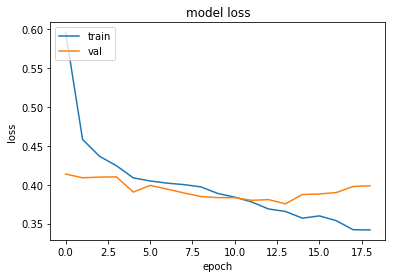

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

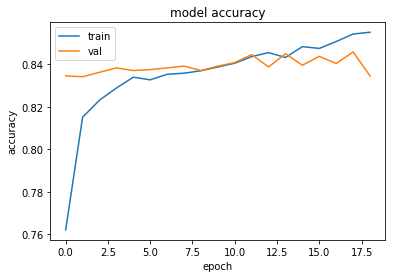

In [60]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [61]:
y_pred = model.predict(test_feed)

In [62]:
y_pred

array([[2.00265626e-09, 2.68944089e-09, 3.78716081e-09, 1.00000000e+00],
       [3.36815077e-07, 6.38288611e-07, 4.66879499e-07, 9.99998569e-01],
       [4.07087319e-02, 1.22644408e-02, 9.42593813e-01, 4.43309452e-03],
       ...,
       [9.84821618e-01, 1.43317403e-02, 8.32798774e-04, 1.38823625e-05],
       [2.04343319e-01, 4.95087028e-01, 1.47460938e-01, 1.53108701e-01],
       [2.72403032e-01, 3.38492246e-05, 7.27532744e-01, 3.04147052e-05]],
      dtype=float32)

In [63]:
#Evaluation Function
import pycm
def evaluate_model(Y_actual, Y_predicted):

    confusion_matrix_class = pycm.ConfusionMatrix(actual_vector=Y_actual,
                                                  predict_vector=Y_predicted)

    TPR = []
    PPV = []
    FPR = []
    FNR = []
    ACC = []
    F1 = []

    TPR.append(confusion_matrix_class.overall_stat['TPR Micro'])
    PPV.append(confusion_matrix_class.overall_stat['PPV Micro'])
    FPR.append(
        round((sum(confusion_matrix_class.FP.values()) /
               (sum(confusion_matrix_class.FP.values()) +
                sum(confusion_matrix_class.TN.values()))), 4))
    FNR.append(
        round((sum(confusion_matrix_class.FN.values()) /
               (sum(confusion_matrix_class.TP.values()) +
                sum(confusion_matrix_class.FN.values()))), 4))
    ACC.append(
        round((sum(confusion_matrix_class.TP.values()) +
               sum(confusion_matrix_class.TN.values())) /
              (sum(confusion_matrix_class.TP.values()) +
               sum(confusion_matrix_class.TN.values()) +
               sum(confusion_matrix_class.FP.values()) +
               sum(confusion_matrix_class.FN.values())), 4))
    F1.append(confusion_matrix_class.overall_stat['F1 Micro'])

    for i in confusion_matrix_class.classes:

        TPR.append(round(float(confusion_matrix_class.class_stat['TPR'][i]),
                         2))

        PPV.append(round(float(confusion_matrix_class.class_stat['PPV'][i]),
                         2))

        FPR.append(round(float(confusion_matrix_class.class_stat['FPR'][i]),
                         2))
        FNR.append(round(float(confusion_matrix_class.class_stat['FNR'][i]),
                         2))

        ACC.append(round(float(confusion_matrix_class.class_stat['ACC'][i]),
                         2))
        F1.append(round(float(confusion_matrix_class.class_stat['F1'][i]), 2))

    eval_df = pd.DataFrame()
    index = ['overall']
    index.extend(confusion_matrix_class.classes)
    eval_df['Recall'] = TPR
    eval_df['Precision'] = PPV
    eval_df['False_Positive_Rate'] = FPR
    eval_df['False_Negative_Rate'] = FNR
    eval_df['Accuracy'] = ACC
    eval_df['F1_Score'] = F1
    eval_df.index = index

    return (eval_df)

In [64]:
y_pred = np.argmax(np.round(y_pred),axis = 1)
evaluate_model(np.array(y_test), y_pred)*100

,Recall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,83.9,83.9,5.37,16.1,91.95,83.9
0,89.0,67.0,15.00,11.0,86.00,77.0
1,74.0,91.0,2.00,26.0,92.00,81.0
2,90.0,90.0,3.00,10.0,95.00,90.0
3,83.0,96.0,1.00,17.0,95.00,89.0
